In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import metrics
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
import seaborn as sns

## Version of Libraries

In [2]:
print('Pandas version: ', pd.__version__)
print("Numpy version: ", np.__version__)
import sklearn
print("Scikit Learn version: ", sklearn.__version__)
print("Keras version: ", keras.__version__)
import matplotlib
print("Matplotlib version: ", matplotlib.__version__)
print("Seaborn version: ", sns.__version__)


Pandas version:  1.3.3
Numpy version:  1.19.5
Scikit Learn version:  1.0
Keras version:  2.6.0
Matplotlib version:  3.4.3
Seaborn version:  0.11.2


## Enabling the GPU usage for tensorflow

In [3]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
print('Amount of GPUs :', len(gpu_devices))
tf.config.experimental.set_memory_growth(gpu_devices[0], True)

Amount of GPUs : 1


## Importing the datasets
To import the datasets, we need to follow along with the relative folder path.

In [13]:
# Importing train dataset
train_data = pd.read_csv('datasets/kdd19/kddtrain.csv')
# Importing test dataset
test_data = pd.read_csv('datasets/kdd19/kddtest.csv')

## Importing columns to the datasets
Original NSL-KDD datasets do not contain any columns name. Therefore, we need to add the names of the columns.

In [18]:
train_data.columns = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]
test_data.columns = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

## Pre-analyzing how many data is contained
- Train dataframe contains the 43 columns which means there are 43 different categories of data fragments. For the data amount, it contains 125972 rows. Therefore, it contain 125972 data tranfers.
- Columns of the test dataframe is the same as train dataframe but test dataframe contains data tranfers fewer than train datafram, 22542 rows.

In [15]:
pd.set_option("display.max_columns", None)

In [16]:
print(train_data.shape)
train_data.head(3)

(125972, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.0,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.1,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.0,30,255,1.0,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21


In [19]:
train_data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
count,125972.000000,1.259720e+05,1.259720e+05,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.0,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,4.556710e+04,1.977927e+04,0.000198,0.022688,0.000111,0.204411,0.001222,0.395739,0.279253,0.001342,0.001103,0.302194,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.108207,27.738093,0.284487,0.282488,0.119959,0.121184,0.660925,0.063053,0.097322,182.149200,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241,19.504056
std,2604.525522,5.870354e+06,4.021285e+06,0.014086,0.253531,0.014366,2.149977,0.045239,0.489011,23.942137,0.036603,0.045155,24.399715,0.483937,0.022181,0.099370,0.0,0.002817,0.096613,114.508828,72.636092,0.446457,0.447024,0.320437,0.323648,0.439624,0.180315,0.259831,99.206565,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460,2.291512
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [20]:
print(test_data.shape)
test_data.head(3)

(22542, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.0,1.0,1.0,0.01,0.06,0.0,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.0,1.0,neptune,21
1,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.0,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.0,0.0,normal,21
2,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.0,0.0,0.0,1.00,0.00,1.0,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.0,0.0,saint,15


In [12]:
test_data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
count,22542.000000,2.254200e+04,2.254200e+04,22542.000000,22542.000000,22542.000000,22542.000000,22542.000000,22542.000000,22542.00000,...,22542.000000,22542.000000,22542.000000,22542.000000,22542.000000,22542.000000,22542.000000,22542.000000,22542.000000,22542.000000
mean,218.878493,1.039637e+04,2.056201e+03,0.000311,0.008429,0.000710,0.105403,0.021648,0.442241,0.11991,...,140.762266,0.608773,0.090521,0.132242,0.019640,0.097822,0.099435,0.233348,0.226659,18.018366
std,1407.237528,4.728074e+05,2.122023e+04,0.017620,0.142605,0.036475,0.928469,0.150334,0.496664,7.26992,...,111.781988,0.435674,0.220705,0.306258,0.085397,0.273149,0.281877,0.387212,0.400857,4.269754
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,15.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,17.000000
50%,0.000000,5.400000e+01,4.600000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,168.000000,0.920000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,2.870000e+02,6.010000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,...,255.000000,1.000000,0.060000,0.030000,0.010000,0.000000,0.000000,0.360000,0.170000,21.000000
max,57715.000000,6.282565e+07,1.345927e+06,1.000000,3.000000,3.000000,101.000000,4.000000,1.000000,796.00000,...,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


## Data Refinement
In this steps, we will check the dirty datasets and check what kind of data types are containing in the dataframes.info() function also shows how many memory usage is took in RAM.

In [ ]:
# For train data
print('If True, it contains nulls: '+ str(train_data.isnull().values.any())) # this is checking entire dataframe
#train_data.isnull().sum() # if there is NaN, check the sum of NaN
print(train_data.info())

If True, it contains nulls: False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised         

In [ ]:
# For test data
print('If True, it contains nulls: '+ str(test_data.isnull().values.any())) # this is checking entire dataframe
#test_data.isnull().sum() # if there is NaN, check the sum of NaN
print(test_data.info())

If True, it contains nulls: False
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22542 entries, 0 to 22541
Data columns (total 42 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22542 non-null  int64  
 1   protocol_type                22542 non-null  object 
 2   service                      22542 non-null  object 
 3   flag                         22542 non-null  object 
 4   src_bytes                    22542 non-null  int64  
 5   dst_bytes                    22542 non-null  int64  
 6   land                         22542 non-null  int64  
 7   wrong_fragment               22542 non-null  int64  
 8   urgent                       22542 non-null  int64  
 9   hot                          22542 non-null  int64  
 10  num_failed_logins            22542 non-null  int64  
 11  logged_in                    22542 non-null  int64  
 12  num_compromised              22542 non-n

## Data Preprocessing
After checking the dirty, we will continue data preprocessing to fit in the model of neural network without having any troubles.

In [ ]:
# dropping the attack columns for TEST DATA
test_data.drop(['attack'], axis = 1, inplace = True)

### Data Preprocessing for the object data
In this step, we will going to change different types of attack columns to just normal and irregular. <br>
First of all, we need to mapping the attack types to which is irregular or nomral.

In [7]:
train_data['attack'].unique()

array(['normal', 'neptune', 'warezclient', 'ipsweep', 'portsweep',
       'teardrop', 'nmap', 'satan', 'smurf', 'pod', 'back',
       'guess_passwd', 'ftp_write', 'multihop', 'rootkit',
       'buffer_overflow', 'imap', 'warezmaster', 'phf', 'land',
       'loadmodule', 'spy', 'perl'], dtype=object)

In [ ]:
map_attacks = {'ipsweep': 'irregular','satan': 'irregular','nmap': 'irregular','portsweep': 'irregular','saint': 'irregular',
'mscan': 'irregular','teardrop': 'irregular','pod': 'irregular','land': 'irregular','back': 'irregular','neptune': 'irregular',
'smurf': 'irregular','mailbomb': 'irregular','udpstorm': 'irregular','apache2': 'irregular','processtable': 'irregular',
'perl': 'irregular','loadmodule': 'irregular','rootkit': 'irregular','buffer_overflow': 'irregular','xterm': 'irregular',
'ps': 'irregular','sqlattack': 'irregular','httptunnel': 'irregular','ftp_write': 'irregular','phf': 'irregular',
'guess_passwd': 'irregular','warezmaster': 'irregular','warezclient': 'irregular','imap': 'irregular','spy': 'irregular',
'multihop': 'irregular','named': 'irregular','snmpguess': 'irregular','worm': 'irregular','snmpgetattack': 'irregular',
'xsnoop': 'irregular','xlock': 'irregular','sendmail': 'irregular','normal': 'normal'}

In [ ]:
# adding and renaming the attack columns to traffic and apply data
# For TRAIN DATA
train_data['traffic'] = train_data['attack'].apply(lambda v: map_attacks[v])

# Predisplay data
train_data.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag,traffic
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.0,0.60,0.88,0.00,0.00,0.00,0.0,0.00,normal,15,normal
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.1,0.05,0.00,0.00,1.00,1.00,0.0,0.00,neptune,19,irregular
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.0,30,255,1.0,0.00,0.03,0.04,0.03,0.01,0.0,0.01,normal,21,normal


In [ ]:
test_data.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
0,0,tcp,private,REJ,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,136,1,0.0,0.0,1.0,1.0,0.01,0.06,0.0,255,1,0.00,0.06,0.00,0.00,0.0,0.0,1.0,1.0,21
1,2,tcp,ftp_data,SF,12983,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0.0,0.0,0.0,0.0,1.00,0.00,0.0,134,86,0.61,0.04,0.61,0.02,0.0,0.0,0.0,0.0,21
2,0,icmp,eco_i,SF,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,65,0.0,0.0,0.0,0.0,1.00,0.00,1.0,3,57,1.00,0.00,1.00,0.28,0.0,0.0,0.0,0.0,15


Dropout the unecessary column "attack" because there was new field 'traffic'

In [ ]:
# For TRAIN DATA
train_data.drop(['attack'], axis=1, inplace=True)

In [ ]:
# display attack modified data
train_data.head(3)
# print(test_data.head(3))

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,traffic
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.0,0.60,0.88,0.00,0.00,0.00,0.0,0.00,15,normal
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.1,0.05,0.00,0.00,1.00,1.00,0.0,0.00,19,irregular
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.0,30,255,1.0,0.00,0.03,0.04,0.03,0.01,0.0,0.01,21,normal


In [ ]:
train_data.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
count,125972.000000,1.259720e+05,1.259720e+05,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.0,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000,125972.000000
mean,287.146929,4.556710e+04,1.977927e+04,0.000198,0.022688,0.000111,0.204411,0.001222,0.395739,0.279253,0.001342,0.001103,0.302194,0.012669,0.000413,0.004096,0.0,0.000008,0.009423,84.108207,27.738093,0.284487,0.282488,0.119959,0.121184,0.660925,0.063053,0.097322,182.149200,115.653725,0.521244,0.082952,0.148379,0.032543,0.284455,0.278487,0.118832,0.120241,19.504056
std,2604.525522,5.870354e+06,4.021285e+06,0.014086,0.253531,0.014366,2.149977,0.045239,0.489011,23.942137,0.036603,0.045155,24.399715,0.483937,0.022181,0.099370,0.0,0.002817,0.096613,114.508828,72.636092,0.446457,0.447024,0.320437,0.323648,0.439624,0.180315,0.259831,99.206565,110.702886,0.448950,0.188922,0.308998,0.112564,0.444785,0.445670,0.306559,0.319460,2.291512
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,82.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,18.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,63.000000,0.510000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000
75%,0.000000,2.760000e+02,5.160000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,143.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000,21.000000
max,42908.000000,1.379964e+09,1.309937e+09,1.000000,3.000000,3.000000,77.000000,5.000000,1.000000,7479.000000,1.000000,2.000000,7468.000000,43.000000,2.000000,9.000000,0.0,1.000000,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125972 entries, 0 to 125971
Data columns (total 43 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     125972 non-null  int64  
 1   protocol_type                125972 non-null  object 
 2   service                      125972 non-null  object 
 3   flag                         125972 non-null  object 
 4   src_bytes                    125972 non-null  int64  
 5   dst_bytes                    125972 non-null  int64  
 6   land                         125972 non-null  int64  
 7   wrong_fragment               125972 non-null  int64  
 8   urgent                       125972 non-null  int64  
 9   hot                          125972 non-null  int64  
 10  num_failed_logins            125972 non-null  int64  
 11  logged_in                    125972 non-null  int64  
 12  num_compromised              125972 non-null  int64  
 13 

### Change and pop out traffic data into dataframe 

Now change the traffic object data to <b>normal = 0 and irregular =  1</b> values.

In [ ]:
# map the traffic data
map_traffic = {'normal': 0,'irregular': 1}
train_data['traffic'] = train_data['traffic'].apply(lambda v: map_traffic[v])

In [ ]:
train_data.head(3)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,traffic
0,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.0,0.60,0.88,0.00,0.00,0.00,0.0,0.00,15,0
1,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.1,0.05,0.00,0.00,1.00,1.00,0.0,0.00,19,1
2,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.0,30,255,1.0,0.00,0.03,0.04,0.03,0.01,0.0,0.01,21,0


Now, pop out traffic field with a variable. <b>important!</b>

In [ ]:
traffic_data = train_data.pop('traffic')

### Finding missing values in test data

In test datafram, some services data are missing ('harvest', 'http_2784', 'urh_i', 'tftp_u', 'aol', 'red_i', 'http_8001').

In [ ]:
print("---------- For Train data ----------")
print("Protocol types are " + str(train_data['protocol_type'].unique()) + ". And total: " + str(train_data['protocol_type'].nunique()))
print("Services are " + str(train_data['service'].unique()) + ". And total: " + str(train_data['service'].nunique()))
print("Flags are " + str(train_data['flag'].unique()) + ". And total: " + str(train_data['flag'].nunique()))
print()
print("---------- For Test data ----------")
print("Protocol types are " + str(test_data['protocol_type'].unique()) + ". And total: " + str(test_data['protocol_type'].nunique()))
print("Services are " + str(test_data['service'].unique()) + ". And total: " + str(test_data['service'].nunique()))
print("Flags are " + str(test_data['flag'].unique()) + ". And total: " + str(test_data['flag'].nunique()))

---------- For Train data ----------
Protocol types are ['udp' 'tcp' 'icmp']. And total: 3
Services are ['other' 'private' 'http' 'remote_job' 'ftp_data' 'name' 'netbios_ns'
 'eco_i' 'mtp' 'telnet' 'finger' 'domain_u' 'supdup' 'uucp_path' 'Z39_50'
 'smtp' 'csnet_ns' 'uucp' 'netbios_dgm' 'urp_i' 'auth' 'domain' 'ftp'
 'bgp' 'ldap' 'ecr_i' 'gopher' 'vmnet' 'systat' 'http_443' 'efs' 'whois'
 'imap4' 'iso_tsap' 'echo' 'klogin' 'link' 'sunrpc' 'login' 'kshell'
 'sql_net' 'time' 'hostnames' 'exec' 'ntp_u' 'discard' 'nntp' 'courier'
 'ctf' 'ssh' 'daytime' 'shell' 'netstat' 'pop_3' 'nnsp' 'IRC' 'pop_2'
 'printer' 'tim_i' 'pm_dump' 'red_i' 'netbios_ssn' 'rje' 'X11' 'urh_i'
 'http_8001' 'aol' 'http_2784' 'tftp_u' 'harvest']. And total: 70
Flags are ['SF' 'S0' 'REJ' 'RSTR' 'SH' 'RSTO' 'S1' 'RSTOS0' 'S3' 'S2' 'OTH']. And total: 11

---------- For Test data ----------
Protocol types are ['tcp' 'icmp' 'udp']. And total: 3
Services are ['private' 'ftp_data' 'eco_i' 'telnet' 'http' 'smtp' 'ftp' 'ldap'

In [ ]:
train_service = train_data['service'].tolist()
test_service = test_data['service'].tolist()
difference=list(set(train_service) - set(test_service))
print("They are services that needs to add after scaling object data " + str(difference))

They are services that needs to add after scaling object data ['urh_i', 'aol', 'tftp_u', 'http_8001', 'red_i', 'http_2784', 'harvest']


### Changing Numerical and Object Data
The numerical values and object data are changed simultaneously. <br>
Numerical values are scaled with StandardScaler and Object data are scaled with get_dummies.

In [ ]:
# importing standard scaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler
standard_scaler = StandardScaler()

# extracting numerical value from dataframe
num_cols_train = train_data.select_dtypes(include=['float64','int64']).columns
num_cols_test = test_data.select_dtypes(include=['float64','int64']).columns

# extracting object value from dataframe
obj_cols_train = train_data.select_dtypes(include=['object']).copy()
obj_cols_test = test_data.select_dtypes(include=['object']).copy()

# scaling numeric data 
scaled_num_train = standard_scaler.fit_transform(train_data.select_dtypes(include=['float64','int64']))
scaled_num_test = standard_scaler.fit_transform(test_data.select_dtypes(include=['float64','int64']))

# scaling object data
dummy_obj_train = pd.get_dummies(obj_cols_train)
dummy_obj_test = pd.get_dummies(obj_cols_test)

# turn into dataframe
pd_scaled_num_train = pd.DataFrame(scaled_num_train, columns=num_cols_train)
pd_scaled_num_test = pd.DataFrame(scaled_num_test, columns=num_cols_test)

# print(obj_cols_train.shape)
# print(obj_cols_test.shape)

# merging both numeric data and object data
train_data = pd.concat([dummy_obj_train, pd_scaled_num_train], axis=1)
test_data = pd.concat([dummy_obj_test, pd_scaled_num_test], axis=1)

In [ ]:
print(train_data.shape)
train_data.head(3)

(125972, 123)


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.11025,-0.007737,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,-0.620987,-0.368112,-0.637213,-0.631933,-0.374364,-0.374433,-1.321420,0.482196,-0.374561,0.734337,-1.035693,-1.161035,2.736839,2.367729,-0.289105,-0.639535,-0.624874,-0.387635,-0.376389,-1.965547
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.11025,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,0.339641,-0.299275,1.602655,1.605095,-0.374364,-0.374433,-1.389660,0.038526,-0.374561,0.734337,-0.809862,-0.938292,-0.174419,-0.480194,-0.289105,1.608750,1.618946,-0.387635,-0.376389,-0.219968
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.11025,-0.007723,-0.002891,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,-0.690851,-0.313042,-0.189239,-0.184527,-0.374364,-0.374433,0.771288,-0.349685,-0.374561,-1.533667,1.258746,1.066393,-0.439079,-0.383106,0.066249,-0.572087,-0.602436,-0.387635,-0.345086,0.652822


In [ ]:
print(test_data.shape)
test_data.head(3)

(22542, 116)


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tim_i,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.155541,-0.021989,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,0.443282,-0.338255,-0.348485,-0.347407,1.830265,1.837729,-1.770871,-0.131433,-0.386982,0.650134,-1.250339,-1.397343,-0.138291,-0.431809,-0.229991,-0.358135,-0.352767,1.979974,1.929264,0.698331
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.154120,0.005471,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,-0.606990,-0.338255,-0.348485,-0.347407,-0.573045,-0.565019,0.629389,-0.362976,-0.386982,-0.636607,-0.489913,0.002818,-0.228911,1.560020,0.004213,-0.358135,-0.352767,-0.602648,-0.565448,0.698331
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.155541,-0.021947,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,-0.606990,0.380328,-0.348485,-0.347407,-0.573045,-0.565019,0.629389,-0.362976,3.557025,-2.029691,-0.749353,0.898002,-0.410152,2.833484,3.048867,-0.358135,-0.352767,-0.602648,-0.565448,-0.706934


### Add 7 Missing service.
Therefore, we need to add the missing services.

In [ ]:
# looping data and added missing service data to test dataset.
label_service = 'service_'
missing = [label_service + x for x in difference] # call difference from above
for col in missing:
    test_data[col] = 0


In [ ]:
print(train_data.shape)
train_data.head(3)

(125972, 123)


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.11025,-0.007737,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,-0.620987,-0.368112,-0.637213,-0.631933,-0.374364,-0.374433,-1.321420,0.482196,-0.374561,0.734337,-1.035693,-1.161035,2.736839,2.367729,-0.289105,-0.639535,-0.624874,-0.387635,-0.376389,-1.965547
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.11025,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,0.339641,-0.299275,1.602655,1.605095,-0.374364,-0.374433,-1.389660,0.038526,-0.374561,0.734337,-0.809862,-0.938292,-0.174419,-0.480194,-0.289105,1.608750,1.618946,-0.387635,-0.376389,-0.219968
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.11025,-0.007723,-0.002891,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,-0.690851,-0.313042,-0.189239,-0.184527,-0.374364,-0.374433,0.771288,-0.349685,-0.374561,-1.533667,1.258746,1.066393,-0.439079,-0.383106,0.066249,-0.572087,-0.602436,-0.387635,-0.345086,0.652822


Check the indexes of service_http_2784,service_urh_i, service_http_8001, service_red_i, service_harvest, service_tftp_u, service_aol

In [ ]:
# find the columns indexes to change the position the missing value
label_service = 'service_'
service_index = [label_service + x for x in difference] 
for i in service_index:
    num = train_data.columns.get_loc(i)
    print(f"Index of {i} column in given dataframe is : {num}")

Index of service_urh_i column in given dataframe is : 67
Index of service_aol column in given dataframe is : 6
Index of service_tftp_u column in given dataframe is : 64
Index of service_http_8001 column in given dataframe is : 30
Index of service_red_i column in given dataframe is : 53
Index of service_http_2784 column in given dataframe is : 28
Index of service_harvest column in given dataframe is : 25


In [ ]:
print(test_data.shape)
test_data.head(3)

(22542, 123)


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_hostnames,service_http,service_http_443,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tim_i,service_time,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,service_urh_i,service_aol,service_tftp_u,service_http_8001,service_red_i,service_http_2784,service_harvest
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.155541,-0.021989,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,0.443282,-0.338255,-0.348485,-0.347407,1.830265,1.837729,-1.770871,-0.131433,-0.386982,0.650134,-1.250339,-1.397343,-0.138291,-0.431809,-0.229991,-0.358135,-0.352767,1.979974,1.929264,0.698331,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.154120,0.005471,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,-0.606990,-0.338255,-0.348485,-0.347407,-0.573045,-0.565019,0.629389,-0.362976,-0.386982,-0.636607,-0.489913,0.002818,-0.228911,1.560020,0.004213,-0.358135,-0.352767,-0.602648,-0.565448,0.698331,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.155541,-0.021947,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,-0.606990,0.380328,-0.348485,-0.347407,-0.573045,-0.565019,0.629389,-0.362976,3.557025,-2.029691,-0.749353,0.898002,-0.410152,2.833484,3.048867,-0.358135,-0.352767,-0.602648,-0.565448,-0.706934,0,0,0,0,0,0,0


## Move missing value to correct position.

In [ ]:
service_http_2784 = test_data.pop('service_http_2784')
test_data.insert(26, 'service_http_2784', service_http_2784)

service_red_i = test_data.pop('service_red_i')
test_data.insert(50, 'service_red_i', service_red_i)

service_urh_i = test_data.pop('service_urh_i')
test_data.insert(63, 'service_urh_i', service_urh_i)

service_http_8001 = test_data.pop('service_http_8001')
test_data.insert(28, 'service_http_8001', service_http_8001)

service_tftp_u = test_data.pop('service_tftp_u')
test_data.insert(62, 'service_tftp_u', service_tftp_u)

service_harvest = test_data.pop('service_harvest')
test_data.insert(24, 'service_harvest', service_harvest)

service_aol = test_data.pop('service_aol')
test_data.insert(6, 'service_aol', service_aol)

print(test_data.shape)
test_data.head(3)

(22542, 123)


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.155541,-0.021989,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,0.443282,-0.338255,-0.348485,-0.347407,1.830265,1.837729,-1.770871,-0.131433,-0.386982,0.650134,-1.250339,-1.397343,-0.138291,-0.431809,-0.229991,-0.358135,-0.352767,1.979974,1.929264,0.698331
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.154120,0.005471,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,-0.606990,-0.338255,-0.348485,-0.347407,-0.573045,-0.565019,0.629389,-0.362976,-0.386982,-0.636607,-0.489913,0.002818,-0.228911,1.560020,0.004213,-0.358135,-0.352767,-0.602648,-0.565448,0.698331
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.155541,-0.021947,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,-0.606990,0.380328,-0.348485,-0.347407,-0.573045,-0.565019,0.629389,-0.362976,3.557025,-2.029691,-0.749353,0.898002,-0.410152,2.833484,3.048867,-0.358135,-0.352767,-0.602648,-0.565448,-0.706934


### Add final traffic field to train data.

In [ ]:
# insert traffic to last column in train dataset
train_data.insert(123, 'traffic', traffic_data)

## Displaying both final datasets

In [ ]:
print(train_data.shape)
train_data.head(3)

(125972, 124)


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,traffic
0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.11025,-0.007737,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,-0.620987,-0.368112,-0.637213,-0.631933,-0.374364,-0.374433,-1.321420,0.482196,-0.374561,0.734337,-1.035693,-1.161035,2.736839,2.367729,-0.289105,-0.639535,-0.624874,-0.387635,-0.376389,-1.965547,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,-0.11025,-0.007762,-0.004919,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,-0.809267,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,0.339641,-0.299275,1.602655,1.605095,-0.374364,-0.374433,-1.389660,0.038526,-0.374561,0.734337,-0.809862,-0.938292,-0.174419,-0.480194,-0.289105,1.608750,1.618946,-0.387635,-0.376389,-0.219968,1
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.11025,-0.007723,-0.002891,-0.014089,-0.089487,-0.007736,-0.095076,-0.027023,1.235686,-0.011664,-0.036652,-0.024437,-0.012385,-0.02618,-0.01861,-0.041221,0.0,-0.002818,-0.097531,-0.690851,-0.313042,-0.189239,-0.184527,-0.374364,-0.374433,0.771288,-0.349685,-0.374561,-1.533667,1.258746,1.066393,-0.439079,-0.383106,0.066249,-0.572087,-0.602436,-0.387635,-0.345086,0.652822,0


In [ ]:
print(test_data.shape)
test_data.head(3)

(22542, 123)


,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service_IRC,service_X11,service_Z39_50,service_aol,service_auth,service_bgp,service_courier,service_csnet_ns,service_ctf,service_daytime,service_discard,service_domain,service_domain_u,service_echo,service_eco_i,service_ecr_i,service_efs,service_exec,service_finger,service_ftp,service_ftp_data,service_gopher,service_harvest,service_hostnames,service_http,service_http_2784,service_http_443,service_http_8001,service_imap4,service_iso_tsap,service_klogin,service_kshell,service_ldap,service_link,service_login,service_mtp,service_name,service_netbios_dgm,service_netbios_ns,service_netbios_ssn,service_netstat,service_nnsp,service_nntp,service_ntp_u,service_other,service_pm_dump,service_pop_2,service_pop_3,service_printer,service_private,service_red_i,service_remote_job,service_rje,service_shell,service_smtp,service_sql_net,service_ssh,service_sunrpc,service_supdup,service_systat,service_telnet,service_tftp_u,service_tim_i,service_time,service_urh_i,service_urp_i,service_uucp,service_uucp_path,service_vmnet,service_whois,flag_OTH,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-0.155541,-0.021989,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,0.443282,-0.338255,-0.348485,-0.347407,1.830265,1.837729,-1.770871,-0.131433,-0.386982,0.650134,-1.250339,-1.397343,-0.138291,-0.431809,-0.229991,-0.358135,-0.352767,1.979974,1.929264,0.698331
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.154120,0.005471,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,-0.606990,-0.338255,-0.348485,-0.347407,-0.573045,-0.565019,0.629389,-0.362976,-0.386982,-0.636607,-0.489913,0.002818,-0.228911,1.560020,0.004213,-0.358135,-0.352767,-0.602648,-0.565448,0.698331
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,-0.155541,-0.021947,-0.0969,-0.017625,-0.059107,-0.01946,-0.113526,-0.144005,-0.890443,-0.016494,-0.049456,-0.012638,-0.01426,-0.012912,-0.024022,-0.05232,0.0,-0.022096,-0.171079,-0.606990,0.380328,-0.348485,-0.347407,-0.573045,-0.565019,0.629389,-0.362976,3.557025,-2.029691,-0.749353,0.898002,-0.410152,2.833484,3.048867,-0.358135,-0.352767,-0.602648,-0.565448,-0.706934


### Cleaning unecessary columns 
num_outbound_cmds are all 0 data in both train and test data. Therefore, drop out all the data of num_outbound_cmds

In [ ]:
# print(train_data['num_outbound_cmds'].value_counts())
# print(test_data['num_outbound_cmds'].value_counts())
# train_data.shape
test_data.shape

(22542, 123)

In [ ]:
train_data.drop(['num_outbound_cmds'], axis=1, inplace=True)
test_data.drop(['num_outbound_cmds'], axis=1, inplace=True)

## Displaying SNS Heatmap Correlation 

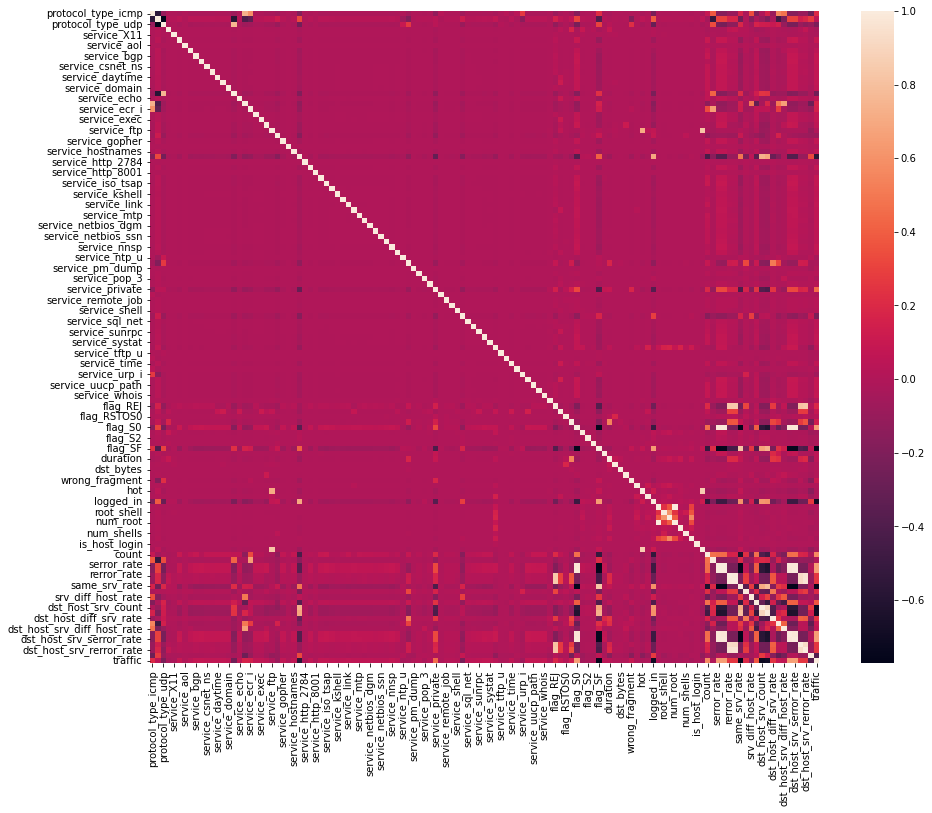

In [ ]:
# correlation
corr = train_data.corr()
plt.figure(figsize=(15,12))
sns.heatmap(corr)
plt.show()

## Redisplay shape of both test and train data

In [ ]:
print(train_data.shape)
print(test_data.shape)

(125972, 123)
(22542, 122)


## Using Machine Learning Method

In [ ]:
from sklearn.model_selection import train_test_split

Maunally spliting data

In [ ]:
target_X = train_data[['traffic']]
# deleting same rows as test to run Gaussian model
target_Y = target_X.drop(labels = range(0, 103430), axis=0)
X_train_data = train_data.drop(['traffic',], axis=1)
X_test_data = test_data
print(X_train_data.shape, target_X.shape)
print(X_test_data.shape, target_Y.shape)

(125972, 122) (125972, 1)
(22542, 122) (22542, 1)


Using train_test_split function from sklearn

In [ ]:
Y = train_data[['traffic']]
X = train_data.drop(['traffic'], axis =1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state =42)
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(84401, 122) (84401, 1)
(41571, 122) (41571, 1)


## Gaussian Naive Bayes

In [ ]:
# Gaussian Naive Bayes
import time
from sklearn.naive_bayes import GaussianNB
GNbayes = GaussianNB()

### Use Manually spliting data

In [ ]:
start_time = time.time()
GNbayes.fit(X_train_data, target_X.values.ravel())
end_time = time.time()
print("Training time: ",end_time-start_time)

Training time:  0.31133222579956055


In [ ]:
start_time = time.time()
prediction1 = GNbayes.predict(test_data)
end_time = time.time()
print("Testing time: ",end_time-start_time)

Testing time:  0.057845354080200195


In [ ]:
# train score
score_1 = (GNbayes.score(X_train_data, target_X))*100
final1 = '{0:.4g}'.format(score_1)
# test score
score_2 = (GNbayes.score(test_data,target_Y))*100
final2 = '{0:.4g}'.format(score_2)

In [ ]:
print("Train score is:", final1, '%')
print("Test score with own splited data is:", final2, '%')

Train score is: 86.59 %
Test score with own splited data is: 46.46 %


### Use train_test_split data

In [ ]:
start_time = time.time()
GNbayes.fit(X_train, Y_train.values.ravel())
end_time = time.time()
print("Fiting time: ",end_time-start_time)

Training time:  0.2044534683227539


In [ ]:
start_time = time.time()
prediction2 = GNbayes.predict(X_test)
end_time = time.time()
print("Prediction time: ",end_time-start_time)

Testing time:  0.09574437141418457


In [ ]:
# train score
score_3 = (GNbayes.score(X_train, Y_train))*100
final3 = '{0:.4g}'.format(score_3)
# test score
score_4 = (GNbayes.score(X_test,Y_test))*100
final4 = '{0:.4g}'.format(score_4)

In [ ]:
print("Train score is:", final3, '%')
print("Test score is:", final4, '%')

Train score is: 86.66 %
Test score is: 86.44 %


## Using Multi-perceptron Layer Neural Network

### Modeling for train_test_split dataset

In [ ]:
# building neural network
keras.backend.clear_session()
model = Sequential()
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(50, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(10, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(Y_train.shape[1],activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'],  optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                1230      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
Total params: 4,853
Trainable params: 4,853
Non-trainable params: 0
______________________________________________________

In [ ]:
# auto stopping training when it reach its limit
from tensorflow.keras.callbacks import EarlyStopping
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, 
                        patience=5, verbose=1, mode='auto',
                           restore_best_weights=True)

### Model fitting in train_test_split data

In [ ]:
# model training
training1 = model.fit(X_train, Y_train, validation_data = (X_test, Y_test), callbacks=[monitor], verbose = 2, epochs=1000)

Epoch 1/1000
2638/2638 - 11s - loss: 0.0436 - accuracy: 0.9865 - val_loss: 0.0166 - val_accuracy: 0.9955
Epoch 2/1000
2638/2638 - 10s - loss: 0.0122 - accuracy: 0.9962 - val_loss: 0.0130 - val_accuracy: 0.9962
Epoch 3/1000
2638/2638 - 9s - loss: 0.0085 - accuracy: 0.9968 - val_loss: 0.0105 - val_accuracy: 0.9971
Epoch 4/1000
2638/2638 - 10s - loss: 0.0068 - accuracy: 0.9975 - val_loss: 0.0094 - val_accuracy: 0.9973
Epoch 5/1000
2638/2638 - 11s - loss: 0.0061 - accuracy: 0.9978 - val_loss: 0.0079 - val_accuracy: 0.9972
Epoch 6/1000
2638/2638 - 14s - loss: 0.0055 - accuracy: 0.9981 - val_loss: 0.0098 - val_accuracy: 0.9977
Epoch 7/1000
2638/2638 - 12s - loss: 0.0046 - accuracy: 0.9983 - val_loss: 0.0097 - val_accuracy: 0.9982
Epoch 8/1000
2638/2638 - 15s - loss: 0.0049 - accuracy: 0.9986 - val_loss: 0.0081 - val_accuracy: 0.9984
Epoch 9/1000
2638/2638 - 12s - loss: 0.0039 - accuracy: 0.9986 - val_loss: 0.0075 - val_accuracy: 0.9984
Epoch 10/1000
2638/2638 - 12s - loss: 0.0037 - accuracy:

In [ ]:
# Validation score on test data
pred = model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(Y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
print(f"Validation score: {score}")

Validation score: 1.0


### Remodeling for own spliting data

In [ ]:
keras.backend.clear_session()
model = Sequential()
model.add(Dense(10, input_dim=X_train_data.shape[1], activation='relu'))
model.add(Dense(50, input_dim=X_train_data.shape[1], activation='relu'))
model.add(Dense(50, input_dim=X_train_data.shape[1], activation='relu'))
model.add(Dense(10, input_dim=X_train_data.shape[1], activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(target_X.shape[1],activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'],  optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 10)                1230      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                550       
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                510       
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 11        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
Total params: 4,853
Trainable params: 4,853
Non-trainable params: 0
______________________________________________________

### Model fitting on own spliting dataset

In [ ]:
training2 = model.fit(X_train_data, target_X, validation_data = (X_test_data, target_Y), callbacks=[monitor], verbose = 2, epochs=1000)

Epoch 1/1000
3937/3937 - 14s - loss: 0.0051 - accuracy: 0.9983 - val_loss: 0.0062 - val_accuracy: 0.9982
Epoch 2/1000
3937/3937 - 14s - loss: 0.0042 - accuracy: 0.9986 - val_loss: 0.0034 - val_accuracy: 0.9991
Epoch 3/1000
3937/3937 - 14s - loss: 0.0043 - accuracy: 0.9987 - val_loss: 0.0035 - val_accuracy: 0.9988
Epoch 4/1000
3937/3937 - 14s - loss: 0.0037 - accuracy: 0.9986 - val_loss: 0.0028 - val_accuracy: 0.9990
Epoch 5/1000
3937/3937 - 14s - loss: 0.0036 - accuracy: 0.9988 - val_loss: 0.0032 - val_accuracy: 0.9988
Epoch 6/1000
3937/3937 - 14s - loss: 0.0034 - accuracy: 0.9989 - val_loss: 0.0039 - val_accuracy: 0.9986
Epoch 7/1000
3937/3937 - 14s - loss: 0.0029 - accuracy: 0.9989 - val_loss: 0.0030 - val_accuracy: 0.9987
Restoring model weights from the end of the best epoch.
Epoch 00007: early stopping


In [ ]:
# Validation score on test data
pred2 = model.predict(X_test_data)
pred2 = np.argmax(target_Y,axis=1)
y_eval2 = np.argmax(target_Y,axis=1)
score2 = metrics.accuracy_score(y_eval2, pred2)
print(f"Validation score: {score2}")

Validation score: 1.0
